## Report for photovoltaic system data analysis

### Introduction
The goal of this project is to analyze the data from a household photovoltaic system. It has been two years since the system was installed, and the data has been collected since then. So we think it could be interesting to look at these data and try to analyze them and put them into context of weather data collected in the same period.

### Planned steps

### Data description
The data includes information about the household overall energy consumption, photovoltaic system production, battery and daily sunlight duration, average temperature, and irradiation. In case of the household energy related data it is collected form year 2022 to 2024. The weather data is collected from year 2022 to 2023.

#### Data sources
Energy related data were collected by app provided by the photovoltaic system manufacturer. So we can assume that the data are accurate and reliable.

Weather data were collected from the Czech Hydrometeorological Institute. In case of the sunlight data and the temperature data, they were collected from weather station that is only 7 km away from the household. So their relevance and accuracy can be considered as high.

In case of the irradiation data, it was collected from the weather station that is 25 km away from the household, so there could be some questions about the relevance of the data but their accuracy can once again be considered as high.

#### Data preprocessing



In [21]:
import pandas as pd

data_type = 'Consumption'
sheet_name = 'Přehled'
folder_path = 'Tables'
first_year = 2022
year_count = 3

data = []
for i in range(year_count):
    data.append(pd.read_excel(f"{folder_path}/{data_type}-{first_year+i}.xlsx", sheet_name=sheet_name, header=None))

# Define table headers to identify each table
headers = [
        ["Měsíc", "Zátěž [kWh]", "Síť [kWh]", "Výkon FVE [kWh]"],
        ["Den", "Zátěž [Wh]", "Síť [Wh]", "Výkon FVE [Wh]"],
        ["Čas", "Zátěž [Wh]", "Síť [Wh]", "Výkon FVE [Wh]"]
    ]

# Function to find where a specific table starts
def find_table_start(df, header_row):
    for i in range(len(df)):
        if df.iloc[i, :len(header_row)].tolist() == header_row:
            return i
    return -1

# Extract each table based on its header
tables = []
for data in data:
    for i in range(len(headers)):
        start_index = find_table_start(data, headers[i])
        end_index = find_table_start(data, headers[i+1]) if i+1 < len(headers) else len(data)
        if start_index != -1:
            # Extract the table
            table = data.iloc[start_index+1:end_index]  # Skip the header itself
            table.columns = data.iloc[start_index]  # Set the header row
            table = table.dropna(how='all', axis=0)  # Drop rows that are completely empty
            table = table.dropna(how='all', axis=1)  # Drop columns that are completely empty
            tables.append(table)
        else:
            print(f"Header {headers[i]} not found!")

# Merge tables with the same headers in correct order
for i in range(year_count):
    for j in range(len(headers)):
        if i == 0 and j == 0:
            continue
        tables[j] = pd.concat([tables[j], tables[j + len(headers) * i]], ignore_index=True)

tables = tables[:len(headers)]

monthly_energy_data, daily_energy_data, hourly_energy_data = tables

# Convert 'Měsíc' and 'Den' to datetime
monthly_energy_data['Měsíc'] = pd.to_datetime(monthly_energy_data['Měsíc'], format='%m/%Y')
daily_energy_data['Den'] = pd.to_datetime(daily_energy_data['Den'], format='%d/%m/%Y')

    # Display the first few rows of each table
    # print("Monthly Data:")
    # print(monthly_data.head())
    #
    # print("\nDaily Data:")
    # print(daily_data.head())
    #
    # print("\nHourly Data:")
    # print(hourly_data.head())
    #
    # Save tables to CSV files
    # monthly_data.to_csv(f"{folder_path}/monthly_{data_type.lower()}.csv", index=False)
    # daily_data.to_csv(f"{folder_path}/daily_{data_type.lower()}.csv", index=False)
    # hourly_data.to_csv(f"{folder_path}/hourly_{data_type.lower()}.csv", index=False)

monthly_energy_data

,Měsíc,Zátěž [kWh],Síť [kWh],Výkon FVE [kWh]
0,2022-04-01,399,92,464
1,2022-05-01,612,69,766
2,2022-06-01,627,77,760
3,2022-07-01,614,72,762
4,2022-08-01,391,52,529
5,2022-09-01,514,102,609
6,2022-10-01,470,131,517
7,2022-11-01,453,251,339
8,2022-12-01,457,392,184
9,2023-01-01,477,338,266


In [18]:
import pandas as pd

# file_path = 'Tables/sunlight-original.csv'
file_path = 'Tables/Irradiation-original.csv'

org_sep = ';'
first_year = 2022

# load data
data = pd.read_csv(file_path, sep=org_sep)

# delete rows from before the first year
data = data[data['Rok'] >= first_year]

# transform data
org_header = ['Rok', 'Měsíc', 'Den', 'Poznámka']

new_header = ['Date', 'Irradiation [kJ/m²]'] # date format: dd/mm/yyyy
new_sep = ','

data['Date'] = data['Den'].astype(str) + '/' + data['Měsíc'].astype(str) + '/' + data['Rok'].astype(str)
data = data.drop(columns=org_header)
data = data.rename(columns={'Hodnota': 'Irradiation [kJ/m²]'})
data = data[new_header]

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

daily_irradiation_data = data

daily_irradiation_data

,Date,Irradiation [kJ/m²]
13880,2022-01-01,1684
13881,2022-01-02,2251
13882,2022-01-03,3339
13883,2022-01-04,1324
13884,2022-01-05,1505
...,...,...
14605,2023-12-27,4230
14606,2023-12-28,1155
14607,2023-12-29,3440
14608,2023-12-30,2995


#### Preprocessed data description

### Exploratory analysis
#### Monthly energy consumption visualization


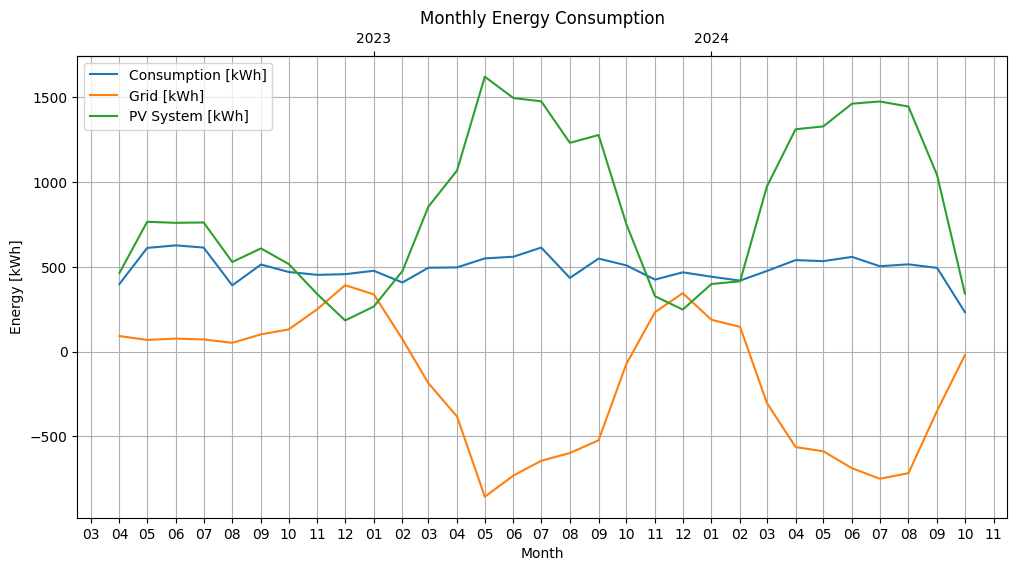

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

data = monthly_energy_data

# Plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['Měsíc'], data['Zátěž [kWh]'], label='Consumption [kWh]')
ax.plot(data['Měsíc'], data['Síť [kWh]'], label='Grid [kWh]')
ax.plot(data['Měsíc'], data['Výkon FVE [kWh]'], label='PV System [kWh]')

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Energy [kWh]')
ax.set_title('Monthly Energy Consumption')
ax.legend()
ax.grid()

# Format the x-axis to show months and years
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%m'))
ax.xaxis.set_minor_locator(dates.YearLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('\n%Y'))

# Add a secondary x-axis for the years
secax = ax.secondary_xaxis('top')
secax.xaxis.set_major_locator(dates.YearLocator())
secax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

# Show the plot
plt.show()



#### Monthly PV system production in context of irradiation for year 2023 visualization


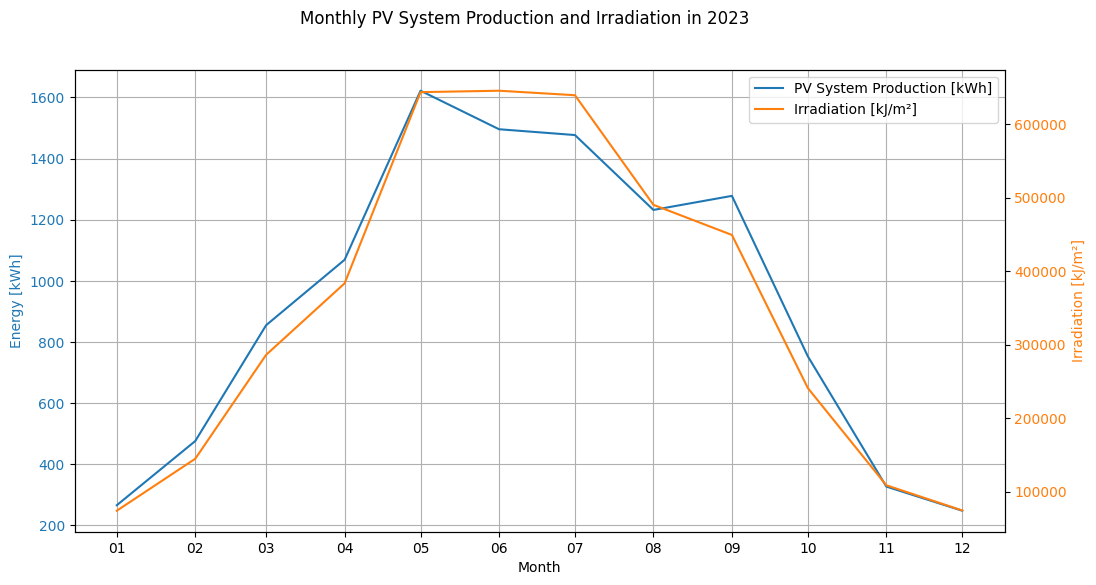

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

production_data = monthly_energy_data
irradiation_data = daily_irradiation_data

# Filter data for the year 2023
production_data_2023 = production_data[production_data['Měsíc'].dt.year == 2023]
irradiation_data_2023 = irradiation_data[daily_irradiation_data['Date'].dt.year == 2023]

# Set 'Date' as the index for irradiation data
irradiation_data_2023.set_index('Date', inplace=True)

# Sum irradiation values for each month in 2023
irradiation_data_2023 = irradiation_data_2023.resample('MS').sum()

# Plot data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot PV System Production
ax1.plot(production_data_2023['Měsíc'], production_data_2023['Výkon FVE [kWh]'], label='PV System Production [kWh]', color='tab:blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy [kWh]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for Irradiation
ax2 = ax1.twinx()
ax2.plot(irradiation_data_2023.index, irradiation_data_2023['Irradiation [kJ/m²]'], label='Irradiation [kJ/m²]', color='tab:orange')
ax2.set_ylabel('Irradiation [kJ/m²]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set title and grid
fig.suptitle('Monthly PV System Production and Irradiation in 2023')
ax1.grid()

# Format the x-axis to show only the months of 2023
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('%m'))

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88))

# Show the plot
plt.show()



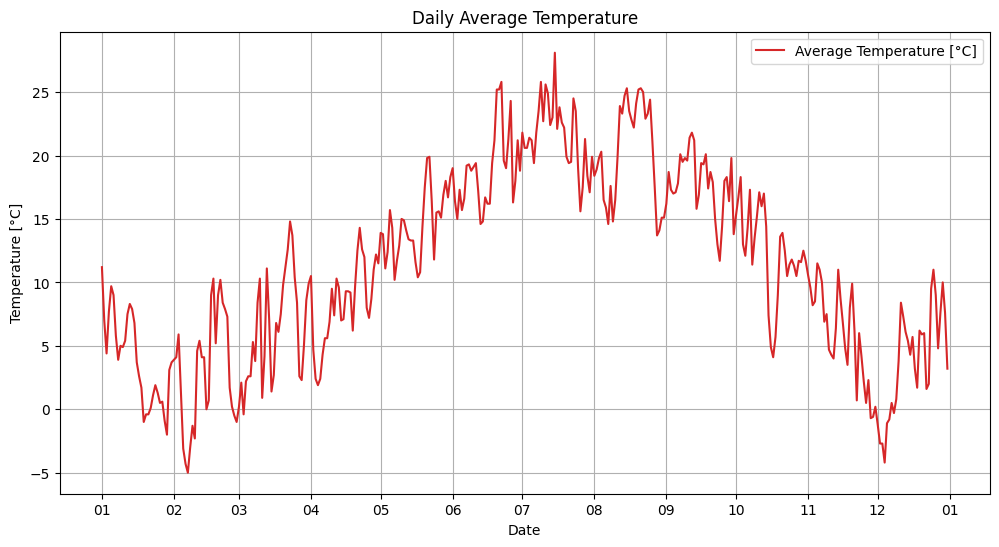

,Date,Average Temperature [°C]
22645,2023-01-01,11.2
22646,2023-01-02,7.0
22647,2023-01-03,4.4
22648,2023-01-04,7.7
22649,2023-01-05,9.7
...,...,...
23005,2023-12-27,4.8
23006,2023-12-28,7.6
23007,2023-12-29,10.0
23008,2023-12-30,7.6


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

file_path = 'Tables/temperature-original.csv'

org_sep = ';'
first_year = 2023

# load data
data = pd.read_csv(file_path, sep=org_sep)

# delete rows from before the first year
data = data[data['Rok'] >= first_year]

# transform data
org_header = ['Rok', 'Měsíc', 'Den', 'Poznámka']

new_header = ['Date', 'Average Temperature [°C]'] # date format: dd/mm/yyyy

data['Date'] = data['Den'].astype(str) + '/' + data['Měsíc'].astype(str) + '/' + data['Rok'].astype(str)
data = data.drop(columns=org_header)
data = data.rename(columns={'Hodnota': 'Average Temperature [°C]'})
data = data[new_header]

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

daily_temperature_data = data

# plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_temperature_data['Date'], daily_temperature_data['Average Temperature [°C]'], label='Average Temperature [°C]', color='tab:red')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Daily Average Temperature')
ax.legend()
ax.grid()

# Format the x-axis to show only the months of 2023
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%m'))

# Show the plot
plt.show()

daily_temperature_data

### Data transformation
Now we would like to measure the efficiency of the photovoltaic system. In order to do that we should convert the data to the same units. We will convert the irradiation data from `kJ/m²` to `Wh/m²`, and then we will calculate the efficiency of the photovoltaic system as the ratio of the produced energy to the received irradiation on the area of the photovoltaic panels.

#### kJ/m² to received Wh conversion
The conversion coefficient is approximately `1 kJ/m² = 0.27778 Wh/m²`. The photovoltaic panels have an area of approximately `42 m²`. So we can calculate the received energy in Wh as follows: `irradiation * 0.27778 * 42`.

#### Efficiency calculation
We will express the efficiency as a percentage of the received energy that was converted to electrical energy. The formula for efficiency is: `(produced energy / received energy) * 100`.

Using the above formulas, we can calculate the efficiency for each day in the dataset. Because of missing and misleading data, we will calculate the efficiency only for the year 2023.

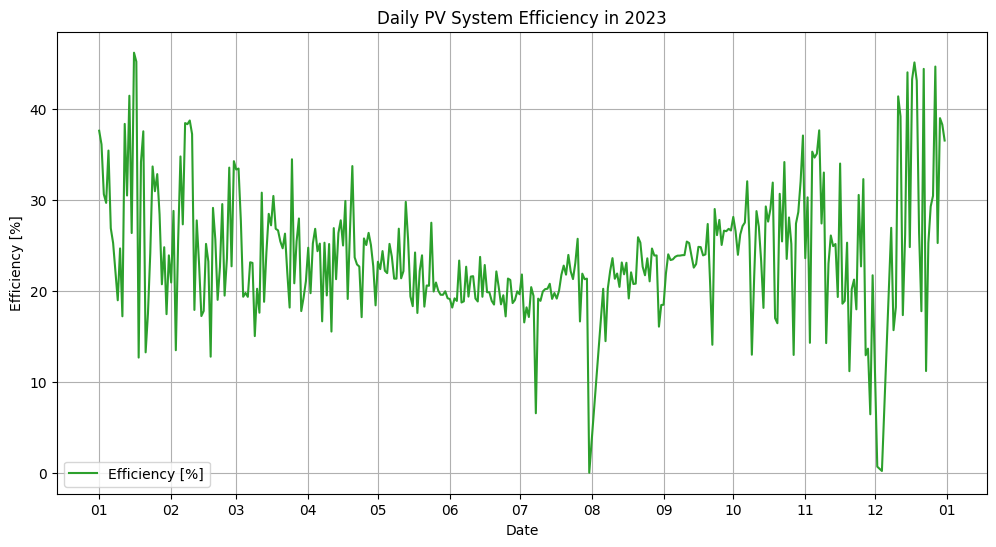

,Efficiency
Den,
2023-01-01,37.590818
2023-01-02,36.089152
2023-01-03,30.619994
2023-01-04,29.661704
2023-01-05,35.410753
...,...
2023-12-27,44.64402
2023-12-28,25.246551
2023-12-29,38.974771


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# Filter data for the year 2023
energy_data_2023 = daily_energy_data[daily_energy_data['Den'].dt.year == 2023]
irradiation_data_2023 = daily_irradiation_data[daily_irradiation_data['Date'].dt.year == 2023]

# Set 'Den' as the index for energy data
energy_data_2023.set_index('Den', inplace=True)

# Set 'Date' as the index for irradiation data
irradiation_data_2023.set_index('Date', inplace=True)

# Create a new DataFrame to store the calculated efficiency
efficiency_data_2023 = pd.DataFrame(index=energy_data_2023.index, columns=['Efficiency'])

# Calculate the efficiency for each day in 2023
for date in energy_data_2023.index:
    irradiation = irradiation_data_2023.loc[date, 'Irradiation [kJ/m²]']
    produced_energy = energy_data_2023.loc[date, 'Výkon FVE [Wh]']
    received_energy = irradiation * 0.27778 * 42  # Convert kJ/m² to Wh for 42 m²
    efficiency = (produced_energy / received_energy) * 100
    efficiency_data_2023.loc[date, 'Efficiency'] = efficiency

# Plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(efficiency_data_2023.index, efficiency_data_2023['Efficiency'], label='Efficiency [%]', color='tab:green')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Efficiency [%]')
ax.set_title('Daily PV System Efficiency in 2023')
ax.legend()
ax.grid()

# Format the x-axis to show only the months of 2023
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%m'))

# Show the plot
plt.show()

efficiency_data_2023

### Data analysis
#### Correlation between temperature and efficiency
Now we would like to analyze the correlation between the average daily temperature and the efficiency of the photovoltaic system. First of all we will visualize the data to see if there is any visible correlation.

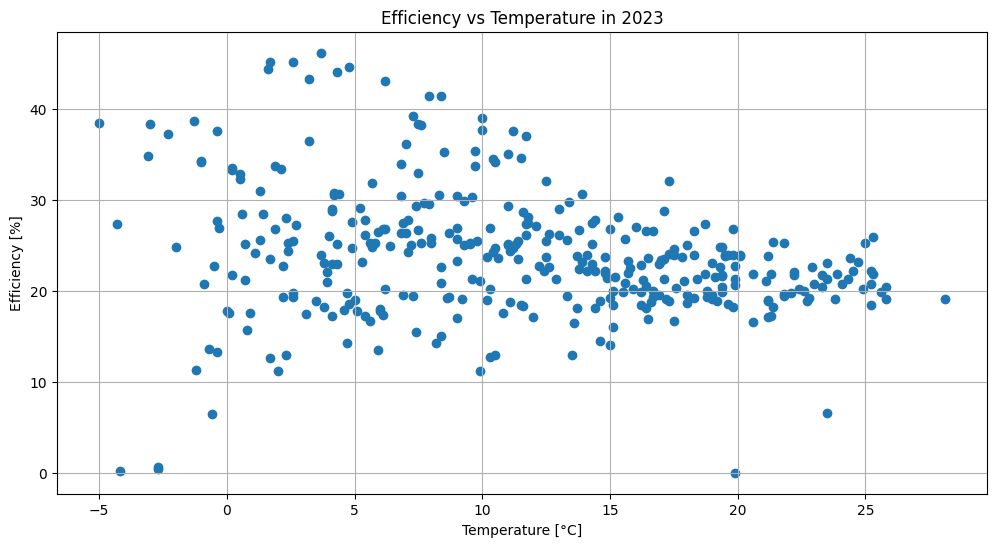

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# Merge efficiency and temperature data
efficiency_temperature_data = efficiency_data_2023.merge(daily_temperature_data, left_index=True, right_on='Date')

# Plot data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Efficiency and Temperature relation as scatter plot where y-axis is Efficiency and x-axis is Temperature
ax1.scatter(efficiency_temperature_data['Average Temperature [°C]'], efficiency_temperature_data['Efficiency'], color='tab:blue')
ax1.set_xlabel('Temperature [°C]')
ax1.set_ylabel('Efficiency [%]')
ax1.set_title('Efficiency vs Temperature in 2023')
ax1.grid()

# Show the plot
plt.show()

The scatter plot doesn't show a clear linear relationship between the average daily temperature and the efficiency of the photovoltaic system. However, we can see that the efficiency tends to decrease slightly as the temperature increases or at least the efficiency becomes more scattered to higher values as the temperature decreases. This could indicate that there might be another factor influencing the efficiency at lower temperatures. For example, the varying cloud cover during colder days, because as stated before, the irradiation data was collected from a weather station that is 25 km away from the household.

#### Correlation coefficient calculation
As another sanity check we can calculate the correlation coefficient between the average daily temperature and the efficiency of the photovoltaic system.

The correlation coefficient ranges from -1 to 1, where:
- 1 indicates a perfect positive linear relationship,
- -1 indicates a perfect negative linear relationship, and
- 0 indicates no linear relationship between the two variables.

The formula for the correlation coefficient is: `cov(X, Y) / (std(X) * std(Y))`, where `cov` is the covariance and `std` is the standard deviation. The correlation coefficient can be calculated using the `corr` method in pandas. We will calculate the correlation coefficient for the year 2023.


In [36]:
# Calculate the correlation coefficient between temperature and efficiency
correlation_coefficient = efficiency_temperature_data['Average Temperature [°C]'].corr(efficiency_temperature_data['Efficiency'])

correlation_coefficient

np.float64(-0.24386786995380025)

Given the correlation coefficient value, we can conclude that there is a weak negative correlation between the average daily temperature and the efficiency of the photovoltaic system. This means that as the temperature increases, the efficiency of the photovoltaic system decreases slightly.

### Modelling using regression
Now knowing that there is a weak negative correlation between the average daily temperature and the efficiency of the photovoltaic system, we can try to model this relationship using linear regression.

#### Linear regression model
The only predictor variable we have is the average daily temperature, and the target variable is the efficiency of the photovoltaic system, so the linear regression model will have the form: `Efficiency_i = β_0 + β_1 * Temperature_i + ε_i`, where:
- `Efficiency_i` is the efficiency of the photovoltaic system on day `i`,
- `Temperature_i` is the average daily temperature on day `i`,
- `β_0` is the intercept of the regression line,
- `β_1` is the slope of the regression line, and
- `ε_i` is the error term for day `i`.
The goal is to estimate the coefficients `β_0` and `β_1` that minimize the sum of squared errors.





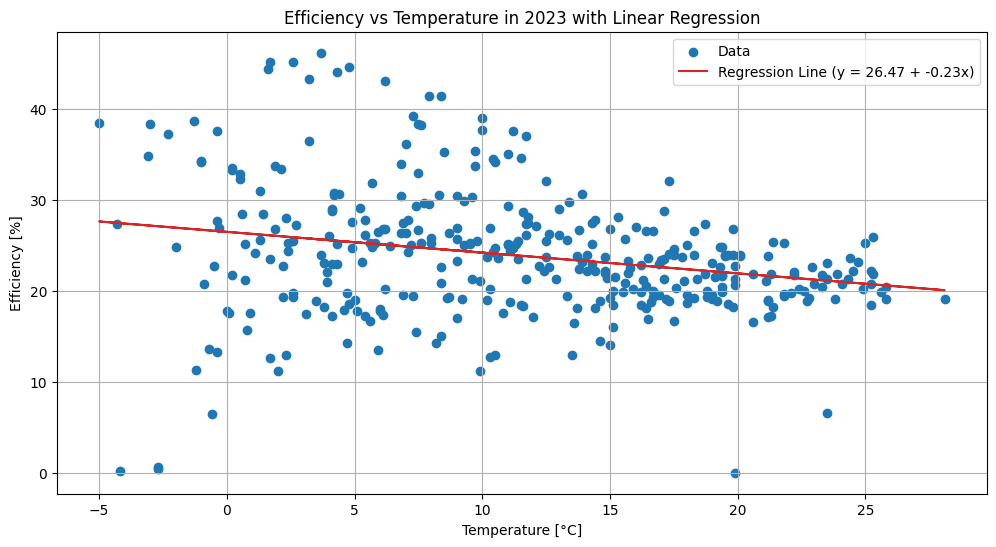

(np.float64(26.474760611540678), np.float64(-0.2282220429430176))

In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the data for linear regression
X = efficiency_temperature_data['Average Temperature [°C]'].values.reshape(-1, 1)
y = efficiency_temperature_data['Efficiency'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# plot the linear regression line
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X, y, color='tab:blue', label='Data')
ax.plot(X, model.predict(X), color='tab:red', label=f'Regression Line (y = {intercept:.2f} + {slope:.2f}x)')
ax.set_xlabel('Temperature [°C]')
ax.set_ylabel('Efficiency [%]')
ax.set_title('Efficiency vs Temperature in 2023 with Linear Regression')
ax.legend()
ax.grid()

# Show the plot
plt.show()

intercept, slope

The estimated coefficients of the linear regression model are approximately:
- Intercept (β_0): 26.474760611540678
- Slope (β_1): -0.2282220429430176

The estimated linear regression model is: `Efficiency = 26.47 - 0.23 * Temperature` and that means that the efficiency of the photovoltaic system decreases by 0.23% for every 1°C increase in the average daily temperature.